# Bayesian Model Comparison on Gaussian Processes

This notebook demonstrates how to perform Bayesian model comparison with the `compass` package on the example of Gaussian processes.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,5'

In [6]:
from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

In [7]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Hypothesis 1
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(x_2; 0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [8]:
def gen_data_hyp1(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [9]:
theta1, x1 = gen_data_hyp1(100_000)
val_theta1, val_x1 = gen_data_hyp1(1_000)

nodes_max = theta1.shape[1] + x1.shape[1]

## Hypothesis 2
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \cos(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(x_2; 0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [10]:
def gen_data_hyp2(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.cos(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [11]:
theta2, x2 = gen_data_hyp2(100_000)
val_theta2, val_x2 = gen_data_hyp2(1_000)

## Hypothesis 3
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 5^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta_1), 2^2) \\
    x_2 &\sim \mathcal{N}(x_2; \theta_1^2, (0.5 \cdot x_1)^2)
\end{align*} $$

In [8]:
def gen_data_hyp3(int):
    theta1 = 5 * torch.randn(int)
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 2
    x2 = theta1**2 + 0.5*x1 * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [9]:
theta3, x3 = gen_data_hyp3(100_000)
val_theta3, val_x3 = gen_data_hyp3(1_000)

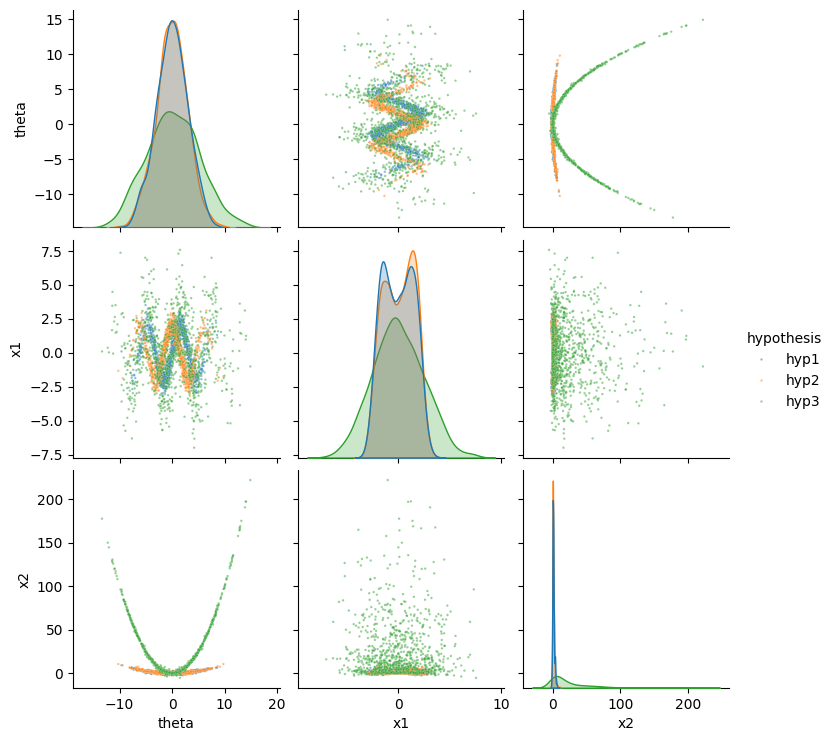

In [10]:
df1 = pd.DataFrame(torch.concatenate([val_theta1, val_x1], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df2 = pd.DataFrame(torch.concatenate([val_theta2, val_x2], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df3 = pd.DataFrame(torch.concatenate([val_theta3, val_x3], dim=1).numpy(), columns=['theta', 'x1', 'x2'])

df1["hypothesis"] = "hyp1"
df2["hypothesis"] = "hyp2"
df3["hypothesis"] = "hyp3"

combined_df = pd.concat([df1, df2, df3], axis=0)

sns.pairplot(combined_df, diag_kind='kde', hue='hypothesis', plot_kws=dict(alpha=0.5, s=3))
plt.show()

In [13]:
mtf = MTf(path="tests")

In [12]:
mtf.add_data("Hypothesis 1", theta1, x1, val_theta1, val_x1)
mtf.add_data("Hypothesis 2", theta2, x2, val_theta2, val_x2)
mtf.add_data("Hypothesis 3", theta3, x3, val_theta3, val_x3)

Data added to model Hypothesis 1
Data added to model Hypothesis 2
Data added to model Hypothesis 3


In [13]:
mtf.init_models(sde_type="vesde", sigma=10, depth=4, num_heads=4, hidden_size=64, mlp_ratio=4)

Models initialized: ['Hypothesis 1', 'Hypothesis 2', 'Hypothesis 3']


In [14]:
mtf.train_models(verbose=False)

Model Hypothesis 1 trained
Model Hypothesis 2 trained
Model Hypothesis 3 trained


In [15]:
# sbim1 = SBIm.load("tests/Hypothesis 1_checkpoint.pt", device="cuda")
# sbim2 = SBIm.load("tests/Hypothesis 2_checkpoint.pt", device="cuda")
# sbim3 = SBIm.load("tests/Hypothesis 3_checkpoint.pt", device="cuda")

# mtf.add_model("Hypothesis 1", sbim1)
# mtf.add_model("Hypothesis 2", sbim2)
# mtf.add_model("Hypothesis 3", sbim3)

In [16]:
# Create test data
test_theta1, test_x1 = gen_data_hyp1(100)

# Compare models on test data
mtf.compare(x=test_x1, device="cuda", timesteps=500)

Probabilities of the models after 100 observations:
Hypothesis 1:  13.26 %
Hypothesis 2:   0.00 %
Hypothesis 3:  86.74 %

Model Hypothesis 3 fits the data best with a relative support of 86.7% among the considered models and could reject the null hypothesis decisively.


In [14]:
mtf.plot_comparison()

AttributeError: 'ModelTransfuser' object has no attribute 'plot_comparison'

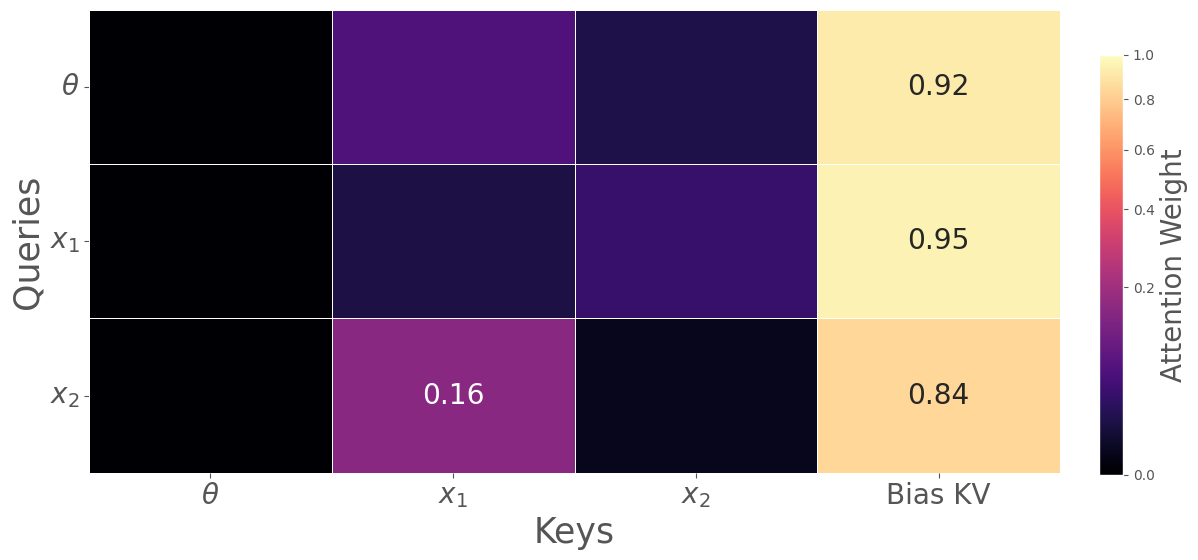

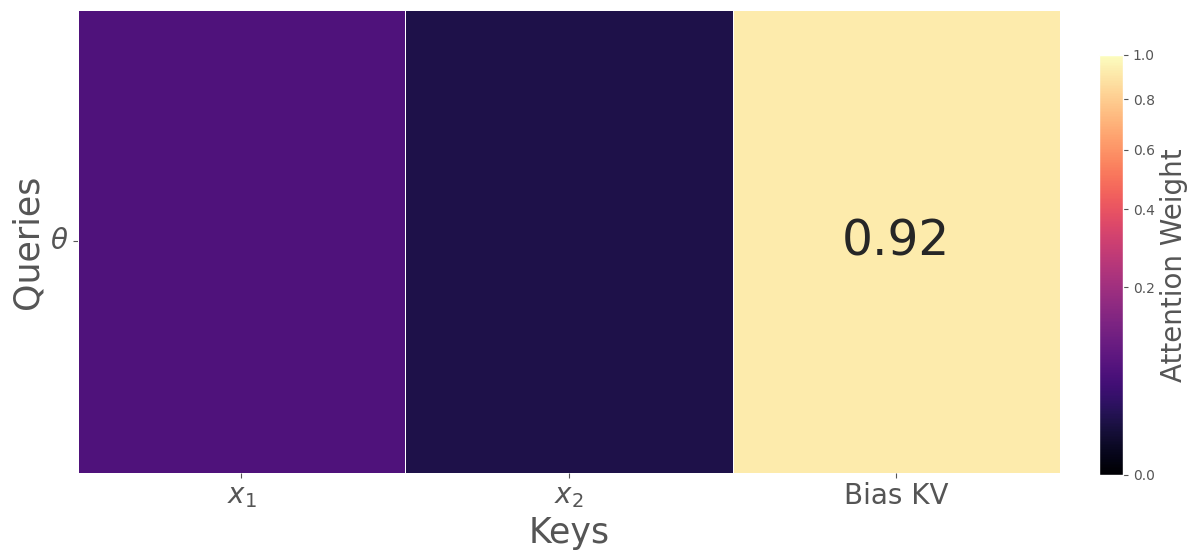

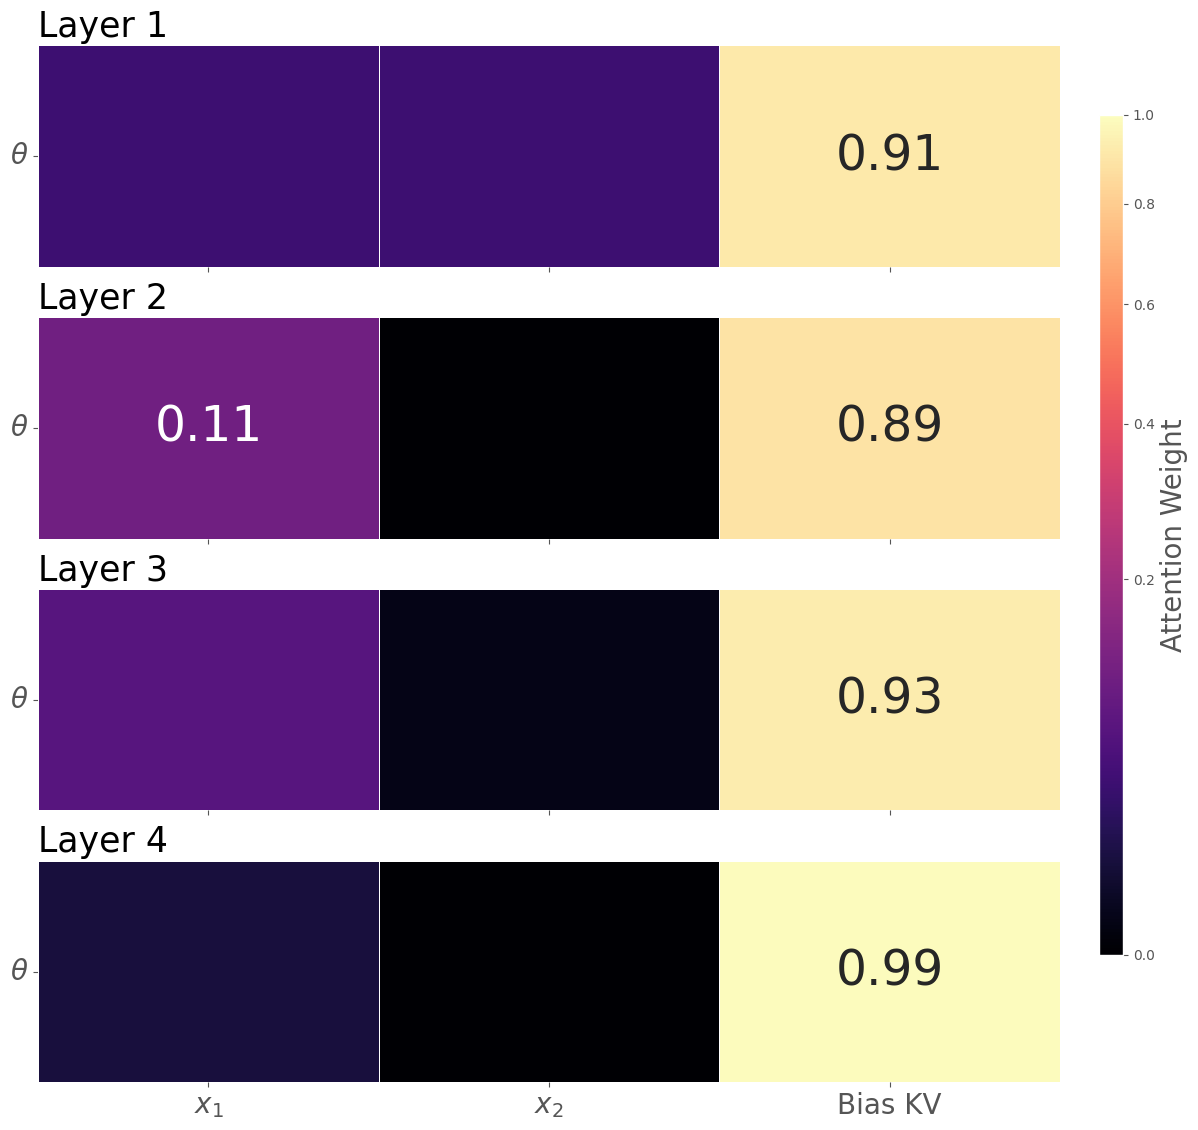

In [18]:
mtf.plot_attention(labels=[r"$\theta$", r"$x_1$", r"$x_2$"])

In [19]:
import pickle

with open("tests/model_comp.pkl", "rb") as f:
    results = pickle.load(f)

In [37]:
100*((test_theta1- results["Hypothesis 1"]["MAP"][:,0]).abs()/test_theta1.abs()).mean()

tensor(89.0269, dtype=torch.float64)

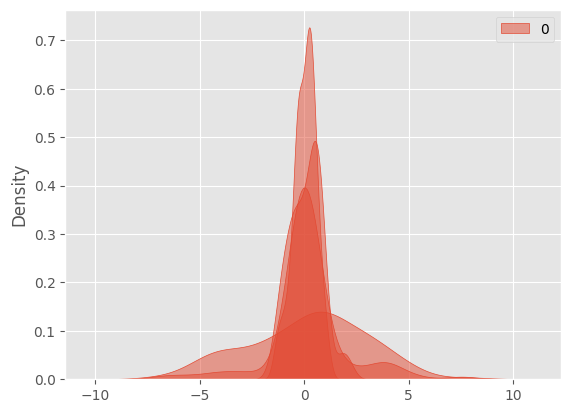

In [47]:
sns.kdeplot(test_theta1, label="True $\theta$", color="k", fill=True, alpha=0.5)
sns.kdeplot(results["Hypothesis 1"]["MAP"][:,0], label="Estimated $\theta$", color="r", fill=True, alpha=0.5)
sns.kdeplot(results["Hypothesis 2"]["MAP"][:,0], label="Estimated $\theta$", color="b", fill=True, alpha=0.5)
sns.kdeplot(results["Hypothesis 3"]["MAP"][:,0], label="Estimated $\theta$", color="r", fill=True, alpha=0.5)
plt.show()

In [39]:
test_x1[0]

tensor([0.6425, 0.9663])